In [ ]:


# Install TensorFlow first (it will install compatible numpy)
!pip install tensorflow==2.19.0

# Install compatible versions
!pip install "numpy>=1.26.0,<2.2.0"
!pip install albucore==0.0.24
!pip install albumentations==1.4.16
!pip install segmentation-models-pytorch
!pip install timm opencv-python==4.10.0.84 scikit-learn==1.5.2


  Using cached albucore-0.0.17-py3-none-any.whl.metadata (3.1 kB)
Using cached albucore-0.0.17-py3-none-any.whl (10 kB)
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24


In [ ]:
import os, math, glob, random, json, shutil
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

/usr/local/lib/python3.12/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Device: cuda


In [ ]:
# Cell 1: Mount Drive and set split paths (train/val/test each with images/ and masks/)

DATA_ROOT = "/content/drive/MyDrive/spillguard_project/dataset"
TRAIN_IMAGES_DIR = os.path.join(DATA_ROOT, "train", "images")
TRAIN_MASKS_DIR  = os.path.join(DATA_ROOT, "train", "masks")
VAL_IMAGES_DIR   = os.path.join(DATA_ROOT, "val", "images")
VAL_MASKS_DIR    = os.path.join(DATA_ROOT, "val", "masks")
TEST_IMAGES_DIR  = os.path.join(DATA_ROOT, "test", "images")
TEST_MASKS_DIR   = os.path.join(DATA_ROOT, "test", "masks")

# Fixed label colors provided
COLOR_TO_CLASS = {
    (0, 0, 0): "background",
    (255, 0, 124): "oil",
    (255, 204, 51): "others",
    (51, 221, 255): "water",
}
OIL_CLASS_NAME = "oil"
OIL_COLORS = {rgb for rgb, name in COLOR_TO_CLASS.items() if name == OIL_CLASS_NAME}

for d in [TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, VAL_IMAGES_DIR, VAL_MASKS_DIR, TEST_IMAGES_DIR, TEST_MASKS_DIR]:
    assert os.path.isdir(d), f"Missing directory: {d}"
print("Using oil colors:", OIL_COLORS)

Using oil colors: {(255, 0, 124)}


In [ ]:
# Cell 2: Index pairs per split and utilities
def list_image_files(images_dir, exts=(".png", ".jpg", ".jpeg", ".tif", ".tiff")):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(images_dir, f"*{ext}")))
    return sorted(files)

def corresponding_mask_path(image_path, images_dir, masks_dir):
    base = os.path.splitext(os.path.basename(image_path))[0]
    for ext in [".png", ".jpg", ".jpeg", ".tif", ".tiff"]:
        m = os.path.join(masks_dir, base + ext)
        if os.path.isfile(m):
            return m
    return None

def load_sar_grayscale(path):
    try:
        img = Image.open(path)
        if img.mode not in ["L", "I;16", "I;16B", "I"]:
            img = img.convert("L")
        arr = np.array(img)
    except Exception:
        arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if arr is None:
            raise RuntimeError(f"Cannot read image: {path}")
        if arr.ndim == 3:
            arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
    arr = arr.astype(np.float32)
    lo, hi = np.percentile(arr, [1, 99])
    if hi > lo:
        arr = np.clip(arr, lo, hi)
        arr = (arr - lo) / (hi - lo)
    else:
        arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
    return arr

def load_mask_binary(path, oil_colors):
    mask = cv2.imread(path, cv2.IMREAD_COLOR)  # BGR
    if mask is None:
        raise RuntimeError(f"Cannot read mask: {path}")
    rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    h, w, _ = rgb.shape
    bin_mask = np.zeros((h, w), dtype=np.uint8)
    for (r, g, b) in oil_colors:
        matches = (rgb[:, :, 0] == r) & (rgb[:, :, 1] == g) & (rgb[:, :, 2] == b)
        bin_mask[matches] = 1
    return bin_mask

def build_pairs(images_dir, masks_dir):
    pairs = []
    missing = 0
    for ip in list_image_files(images_dir):
        mp = corresponding_mask_path(ip, images_dir, masks_dir)
        if mp is None:
            missing += 1
            continue
        pairs.append((ip, mp))
    return pairs, missing

pairs_train, miss_tr = build_pairs(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR)
pairs_val,   miss_va = build_pairs(VAL_IMAGES_DIR,   VAL_MASKS_DIR)
pairs_test,  miss_te = build_pairs(TEST_IMAGES_DIR,  TEST_MASKS_DIR)

print(f"Train pairs: {len(pairs_train)} (missing masks: {miss_tr})")
print(f"Val pairs:   {len(pairs_val)} (missing masks: {miss_va})")
print(f"Test pairs:  {len(pairs_test)} (missing masks: {miss_te})")

Train pairs: 811 (missing masks: 0)
Val pairs:   203 (missing masks: 0)
Test pairs:  252 (missing masks: 0)


In [ ]:
# Cell 3: Dataset-level stats (positive ratio per split)
def positive_ratio(pairs, oil_colors, sample_max=None):
    idxs = range(len(pairs)) if sample_max is None else np.random.choice(len(pairs), min(len(pairs), sample_max), replace=False)
    pos = 0
    for i in idxs:
        _, mp = pairs[i]
        m = load_mask_binary(mp, oil_colors)
        pos += int(m.any())
    denom = len(idxs) if sample_max is not None else len(pairs)
    return (pos / max(denom, 1)), pos, denom

tr_ratio, tr_pos, tr_den = positive_ratio(pairs_train, OIL_COLORS)
va_ratio, va_pos, va_den = positive_ratio(pairs_val,   OIL_COLORS)
te_ratio, te_pos, te_den = positive_ratio(pairs_test,  OIL_COLORS)

print(f"Train positive ratio: {tr_ratio:.3f} ({tr_pos}/{tr_den})")
print(f"Val positive ratio:   {va_ratio:.3f} ({va_pos}/{va_den})")
print(f"Test positive ratio:  {te_ratio:.3f} ({te_pos}/{te_den})")

Train positive ratio: 0.781 (633/811)
Val positive ratio:   0.803 (163/203)
Test positive ratio:  0.794 (200/252)


In [ ]:
# Cell 4: Augmentations and Dataset for split folders (dtype fixed: ToFloat before noise)
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

IMG_SIZE = 512

train_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    A.RandomCrop(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.ToFloat(max_value=1.0),  # ensure float32 in [0,1] BEFORE noise
    A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=False, elementwise=False, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
    ToTensorV2(),
])

eval_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    A.ToFloat(max_value=1.0),
    ToTensorV2(),
])

class OilSegDataset(Dataset):
    def __init__(self, pairs, augment, oil_colors):
        self.pairs = pairs
        self.augment = augment
        self.oil_colors = oil_colors

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = load_sar_grayscale(img_path)                        # float32 [0,1]
        mask = load_mask_binary(mask_path, self.oil_colors)       # uint8 {0,1}
        img3 = np.stack([img, img, img], axis=2)                  # HWC, 3ch
        augmented = self.augment(image=img3, mask=mask.astype(np.uint8))
        x = augmented["image"].float()                            # [3,H,W]
        y = augmented["mask"].long()                              # [H,W]
        return x, y

ds_train = OilSegDataset(pairs_train, train_tfms, OIL_COLORS)
ds_val   = OilSegDataset(pairs_val,   eval_tfms,  OIL_COLORS)
ds_test  = OilSegDataset(pairs_test,  eval_tfms,  OIL_COLORS)

batch_size = 4  # adjust for your GPU
loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
loader_val   = DataLoader(ds_val,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
loader_test  = DataLoader(ds_test,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Cell 5: Model, Losses, Metrics
ENCODER = "resnet50"
WEIGHTS = "imagenet"
CLASSES = 1  # binary
ACTIVATION = None  # logits out

model = smp.DeepLabV3Plus(encoder_name=ENCODER, encoder_weights=WEIGHTS, in_channels=3, classes=CLASSES).to(device)

# Combined loss: Dice + BCE with positive class weight to handle imbalance
def compute_pos_weight(dataset, sample_count=200):
    # Estimate foreground ratio quickly
    n = min(len(dataset), sample_count)
    idxs = np.random.choice(len(dataset), n, replace=False)
    ones = 0
    total = 0
    for i in idxs:
        _, mask_path = dataset.pairs[i]
        m = load_mask_binary(mask_path, OIL_COLORS)
        ones += m.sum()
        total += m.size
    fg_ratio = ones / max(total, 1)
    if fg_ratio <= 0:
        return torch.tensor([1.0], device=device)
    return torch.tensor([max((1.0 - fg_ratio) / fg_ratio, 1.0)], device=device)

pos_weight = compute_pos_weight(ds_train)
bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

def dice_loss(logits, targets, eps=1e-7):
    probs = torch.sigmoid(logits)
    targets = targets.float()
    intersection = torch.sum(probs * targets, dim=(1,2))
    union = torch.sum(probs, dim=(1,2)) + torch.sum(targets, dim=(1,2))
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def seg_loss(logits, targets):
    # logits: [B,1,H,W], targets: [B,H,W] {0,1}
    logits = logits.squeeze(1)
    return bce(logits, targets.float()) + dice_loss(logits, targets)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
print("pos_weight:", pos_weight.item())

pos_weight: 2.267503533869093


In [ ]:
# Cell 6: Training and Evaluation Utilities
@torch.no_grad()
def compute_metrics_from_logits(logits, targets, threshold=0.5, eps=1e-7):
    # logits: [N,1,H,W], targets: [N,H,W]
    probs = torch.sigmoid(logits).squeeze(1)
    preds = (probs >= threshold).long()

    t = targets.long()
    tp = torch.sum((preds == 1) & (t == 1)).item()
    tn = torch.sum((preds == 0) & (t == 0)).item()
    fp = torch.sum((preds == 1) & (t == 0)).item()
    fn = torch.sum((preds == 0) & (t == 1)).item()

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)

    # IoU and Dice over the batch
    intersection = torch.sum((preds == 1) & (t == 1)).item()
    union = torch.sum((preds == 1) | (t == 1)).item()
    iou = intersection / (union + eps)

    dice = 2 * intersection / (torch.sum(preds == 1).item() + torch.sum(t == 1).item() + eps)

    return {
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "iou": float(iou),
        "dice": float(dice),
    }

@torch.no_grad()
def pr_roc_auc_over_dataset(model, loader, sample_max=200, stride=8):
    # Sample a subset to estimate pixel-level PR-AUC and ROC-AUC
    model.eval()
    probs_list = []
    target_list = []
    count = 0
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).squeeze(1).detach().cpu().numpy()
        t = y.numpy()
        # Subsample pixels with stride to control memory
        probs = probs[:, ::stride, ::stride].reshape(-1)
        t = t[:, ::stride, ::stride].reshape(-1)
        probs_list.append(probs)
        target_list.append(t)
        count += len(x)
        if count >= sample_max:
            break
    probs_all = np.concatenate(probs_list)
    target_all = np.concatenate(target_list)
    roc = roc_auc_score(target_all, probs_all) if len(np.unique(target_all)) > 1 else float("nan")
    pr  = average_precision_score(target_all, probs_all) if len(np.unique(target_all)) > 1 else float("nan")
    return roc, pr

def train_one_epoch(model, loader, optimizer):
    model.train()
    running = 0.0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = seg_loss(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running += loss.item() * x.size(0)
    return running / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader, threshold=0.5):
    model.eval()
    losses = []
    metrics_sum = {"precision":0,"recall":0,"f1":0,"iou":0,"dice":0}
    count = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = seg_loss(logits, y)
        losses.append(loss.item() * x.size(0))
        m = compute_metrics_from_logits(logits, y, threshold)
        for k in metrics_sum:
            metrics_sum[k] += m[k] * x.size(0)
        count += x.size(0)
    metrics_avg = {k: metrics_sum[k] / max(count,1) for k in metrics_sum}
    return (sum(losses)/max(count,1)), metrics_avg

In [ ]:
# Cell 7: Train with checkpointing and resume
EPOCHS = 40
PATIENCE = 6

CKPT_DIR = "/content/drive/MyDrive/oilspill_ckpts"  # change if you want
os.makedirs(CKPT_DIR, exist_ok=True)
CKPT_PATH = os.path.join(CKPT_DIR, "deeplabv3p_last.pth")
BEST_PATH = os.path.join(CKPT_DIR, "deeplabv3p_best.pth")

start_epoch = 1
best_val_score = -1.0
pat = PATIENCE

# Try to resume
if os.path.isfile(CKPT_PATH):
    ckpt = torch.load(CKPT_PATH, map_location=device)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["optimizer"])
    scheduler.load_state_dict(ckpt["scheduler"])
    start_epoch = ckpt["epoch"] + 1
    best_val_score = ckpt.get("best_val_score", -1.0)
    pat = ckpt.get("patience_left", PATIENCE)
    print(f"Resuming from epoch {start_epoch} | best_val_score={best_val_score:.4f} | patience_left={pat}")

best_state = None

for epoch in range(start_epoch, EPOCHS + 1):
    train_loss = train_one_epoch(model, loader_train, optimizer)
    scheduler.step()

    val_loss, val_metrics = eval_epoch(model, loader_val, threshold=0.5)
    val_score = val_metrics["dice"]

    # Save last checkpoint every epoch
    torch.save({
        "epoch": epoch,
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "scheduler": scheduler.state_dict(),
        "best_val_score": best_val_score if best_state is not None else val_score,
        "patience_left": pat,
    }, CKPT_PATH)

    # Save best
    if val_score > best_val_score:
        best_val_score = val_score
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
        torch.save({
            "epoch": epoch,
            "model": best_state,
            "best_val_score": best_val_score,
        }, BEST_PATH)
        pat = PATIENCE
    else:
        pat -= 1

    print(f"Epoch {epoch:02d} | Train {train_loss:.4f} | Val {val_loss:.4f} | {val_metrics}")

    if pat == 0:
        print("Early stopping.")
        break

# Load best weights for evaluation
if os.path.isfile(BEST_PATH):
    best = torch.load(BEST_PATH, map_location="cpu")
    model.load_state_dict({k: v.to(device) for k, v in best["model"].items()})

Resuming from epoch 33 | best_val_score=0.8809 | patience_left=1


In [ ]:
import numpy as np
import torch

@torch.no_grad()
def find_best_threshold_fast(model, loader, search=np.linspace(0.1, 0.9, 17)):
    model.eval()

    all_preds, all_targets = [], []
    for images, masks in loader:
        images = images.to(next(model.parameters()).device)
        preds = torch.sigmoid(model(images))  # raw probability outputs
        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    best_t, best_d = 0.5, -1.0
    for t in search:
        bin_preds = (all_preds > t).float()
        # compute Dice manually
        intersection = (bin_preds * all_targets).sum()
        dice = (2.0 * intersection) / (bin_preds.sum() + all_targets.sum() + 1e-7)

        if dice > best_d:
            best_d = dice
            best_t = float(t)

    return best_t, best_d.item()


In [ ]:

# Cell: Re-define model and load best weights
import torch
import segmentation_models_pytorch as smp
import os

# Define device first
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Re-create model architecture
ENCODER = "resnet50"
WEIGHTS = "imagenet"
CLASSES = 1  # binary
ACTIVATION = None  # logits out

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=WEIGHTS,
    in_channels=3,
    classes=CLASSES
).to(device)

# Load the best trained weights
CKPT_DIR = "/content/drive/MyDrive/oilspill_ckpts"  # change if you want
BEST_PATH = os.path.join(CKPT_DIR, "deeplabv3p_best.pth")

if os.path.isfile(BEST_PATH):
    best = torch.load(BEST_PATH, map_location='cpu')
    model.load_state_dict({k: v.to(device) for k, v in best['model'].items()})
    print("Loaded best model weights")
else:
    print("Best model weights not found!")

Device: cuda
Loaded best model weights


In [ ]:
# COMPLETE CELL: Fix all missing variables and run threshold tuning

import torch
import segmentation_models_pytorch as smp
import os
import numpy as np
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
from PIL import Image
import glob

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Define paths
DATAROOT = "/content/drive/MyDrive/spillguard_project/dataset"
VAL_IMAGES_DIR = os.path.join(DATAROOT, "val", "images")
VAL_MASKS_DIR = os.path.join(DATAROOT, "val", "masks")

# Oil colors
COLOR_TO_CLASS = {
    (0, 0, 0): 'background',
    (255, 0, 124): 'oil',
    (255, 204, 51): 'others',
    (51, 221, 255): 'water',
}

OIL_CLASS_NAME = "oil"
OIL_COLORS = [rgb for rgb, name in COLOR_TO_CLASS.items() if name == OIL_CLASS_NAME]

# Define utility functions
def load_sar_grayscale(path):
    try:
        img = Image.open(path)
        if img.mode not in ('L', 'I;16', 'I;16B', 'I'):
            img = img.convert('L')
        arr = np.array(img)
    except Exception:
        arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if arr is None:
            raise RuntimeError(f"Cannot read image {path}")
        if arr.ndim == 3:
            arr = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)

    arr = arr.astype(np.float32)
    lo, hi = np.percentile(arr, [1, 99])
    if hi > lo:
        arr = np.clip(arr, lo, hi)
        arr = (arr - lo) / (hi - lo)
    else:
        arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
    return arr

def load_mask_binary(path, oil_colors):
    mask = cv2.imread(path, cv2.IMREAD_COLOR)
    if mask is None:
        raise RuntimeError(f"Cannot read mask {path}")
    rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    h, w = rgb.shape[:2]
    bin_mask = np.zeros((h, w), dtype=np.uint8)

    for r, g, b in oil_colors:
        matches = (rgb[:,:,0] == r) & (rgb[:,:,1] == g) & (rgb[:,:,2] == b)
        bin_mask[matches] = 1

    return bin_mask

def list_image_files(images_dir, exts=['.png', '.jpg', '.jpeg', '.tif', '.tiff']):
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(images_dir, f'*{ext}')))
    return sorted(files)

def corresponding_mask_path(image_path, images_dir, masks_dir):
    base = os.path.splitext(os.path.basename(image_path))[0]
    for ext in ['.png', '.jpg', '.jpeg', '.tif', '.tiff']:
        m = os.path.join(masks_dir, base + ext)
        if os.path.isfile(m):
            return m
    return None

def build_pairs(images_dir, masks_dir):
    pairs = []
    missing = 0
    for ip in list_image_files(images_dir):
        mp = corresponding_mask_path(ip, images_dir, masks_dir)
        if mp is None:
            missing += 1
            continue
        pairs.append((ip, mp))
    return pairs, missing

# Build validation pairs
pairs_val, miss_va = build_pairs(VAL_IMAGES_DIR, VAL_MASKS_DIR)
print(f"Validation pairs: {len(pairs_val)}, missing: {miss_va}")

# Create dataset and loader
IMG_SIZE = 512

eval_tfms = A.Compose([
    A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
    A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
    A.ToFloat(max_value=1.0),
    ToTensorV2(),
])

class OilSegDataset:
    def __init__(self, pairs, augment, oil_colors):
        self.pairs = pairs
        self.augment = augment
        self.oil_colors = oil_colors

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = load_sar_grayscale(img_path)
        mask = load_mask_binary(mask_path, self.oil_colors)

        img3 = np.stack([img, img, img], axis=2)
        augmented = self.augment(image=img3, mask=mask.astype(np.uint8))
        x = augmented['image'].float()
        y = augmented['mask'].long()
        return x, y

# Create validation dataset and loader
ds_val = OilSegDataset(pairs_val, eval_tfms, OIL_COLORS)
loader_val = DataLoader(ds_val, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
print(f"Validation loader created with {len(ds_val)} samples")

# Create model
ENCODER = "resnet50"
WEIGHTS = "imagenet"
CLASSES = 1

model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=WEIGHTS,
    in_channels=3,
    classes=CLASSES
).to(device)

# Load best weights
CKPT_DIR = "/content/drive/MyDrive/oilspill_ckpts"
BEST_PATH = os.path.join(CKPT_DIR, "deeplabv3p_best.pth")

if os.path.isfile(BEST_PATH):
    best = torch.load(BEST_PATH, map_location='cpu')
    model.load_state_dict({k: v.to(device) for k, v in best['model'].items()})
    print("✓ Loaded best model weights")
else:
    print("✗ Best model weights not found!")

# Define threshold tuning function
@torch.no_grad()
def find_best_threshold_fast(model, loader, search=np.linspace(0.1, 0.9, 17)):
    model.eval()
    print("Collecting predictions...")

    all_preds, all_targets = [], []
    for images, masks in loader:
        images = images.to(device)
        logits = model(images)
        preds = torch.sigmoid(logits.squeeze(1))  # Convert to probabilities
        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu().float())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    print(f"Predictions shape: {all_preds.shape}, Targets shape: {all_targets.shape}")

    best_t, best_d = 0.5, -1.0
    print("Searching for best threshold...")

    for t in search:
        bin_preds = (all_preds > t).float()
        intersection = (bin_preds * all_targets).sum()
        dice = 2.0 * intersection / (bin_preds.sum() + all_targets.sum() + 1e-7)

        if dice > best_d:
            best_d = dice
            best_t = float(t)

    return best_t, best_d.item()

# Run threshold tuning
print("Starting threshold tuning...")
best_t, best_dice = find_best_threshold_fast(model, loader_val, search=np.linspace(0.1, 0.9, 17))
print(f"✓ Best threshold: {best_t:.3f}, Validation Dice: {best_dice:.4f}")


Device: cuda
Validation pairs: 203, missing: 0
Validation loader created with 203 samples
✓ Loaded best model weights
Starting threshold tuning...
Predictions shape: torch.Size([203, 512, 512]), Targets shape: torch.Size([203, 512, 512])
Searching for best threshold...
✓ Best threshold: 0.650, Validation Dice: 0.9614


✓ Model available
✓ Test loader available
✓ Best threshold: 0.65

RUNNING FINAL TEST EVALUATION
Test Loss: 0.4361
Test Metrics:
  Precision: 0.8131
  Recall: 0.8234
  F1: 0.8146
  Iou: 0.7703
  Dice: 0.8146
Test ROC-AUC: 0.9915
Test PR-AUC: 0.9788

VISUALIZING PREDICTIONS
Generating 6 visualizations with threshold 0.650...


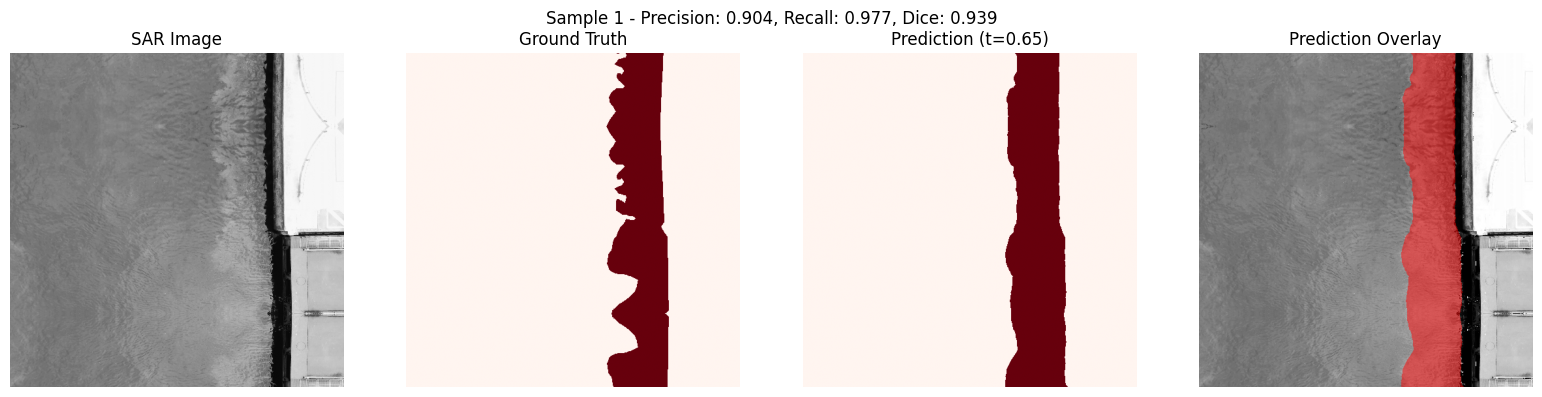

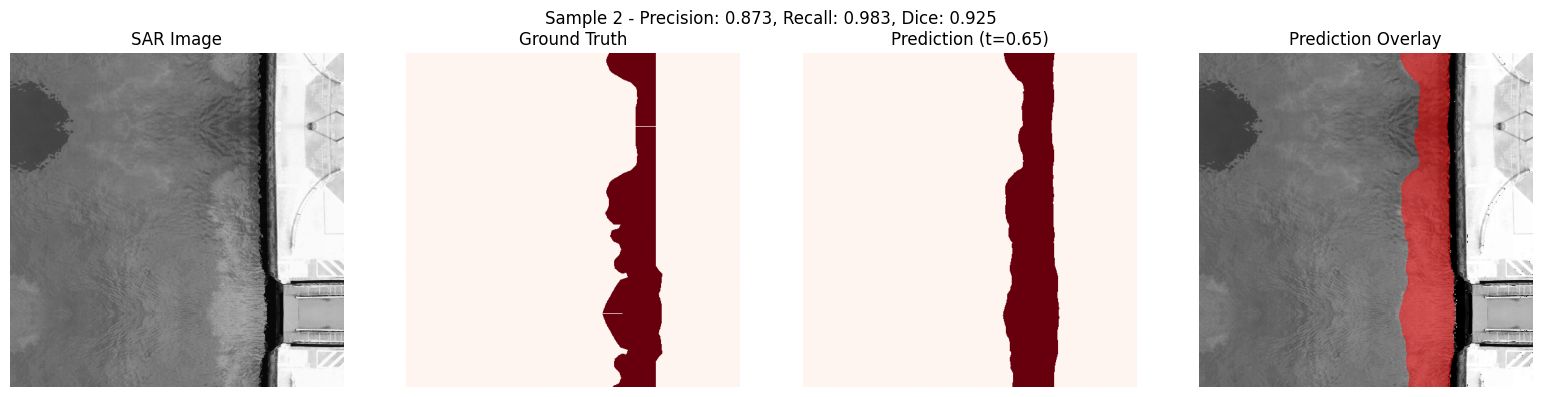

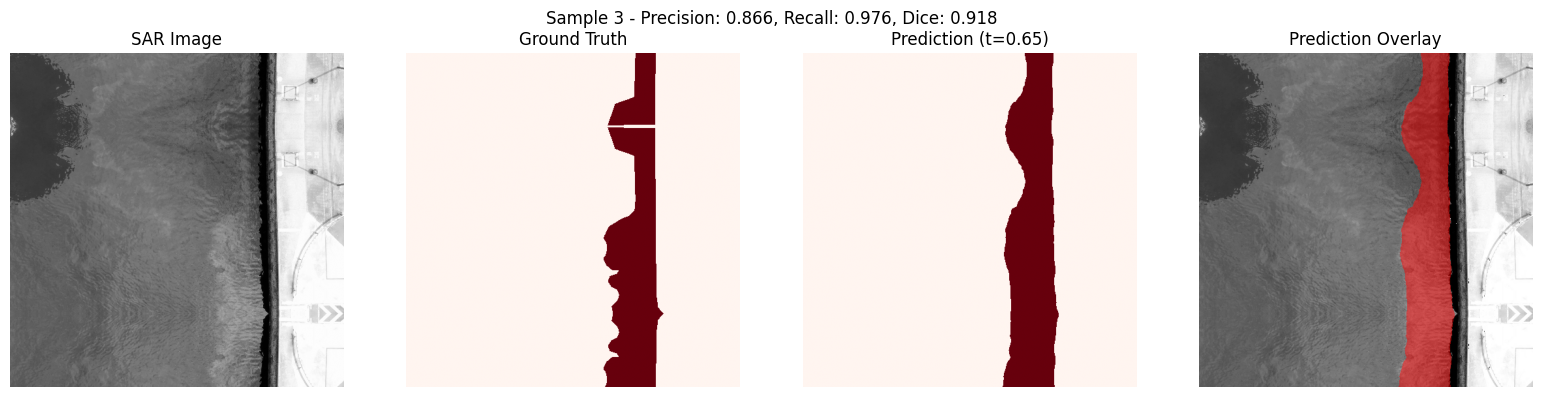

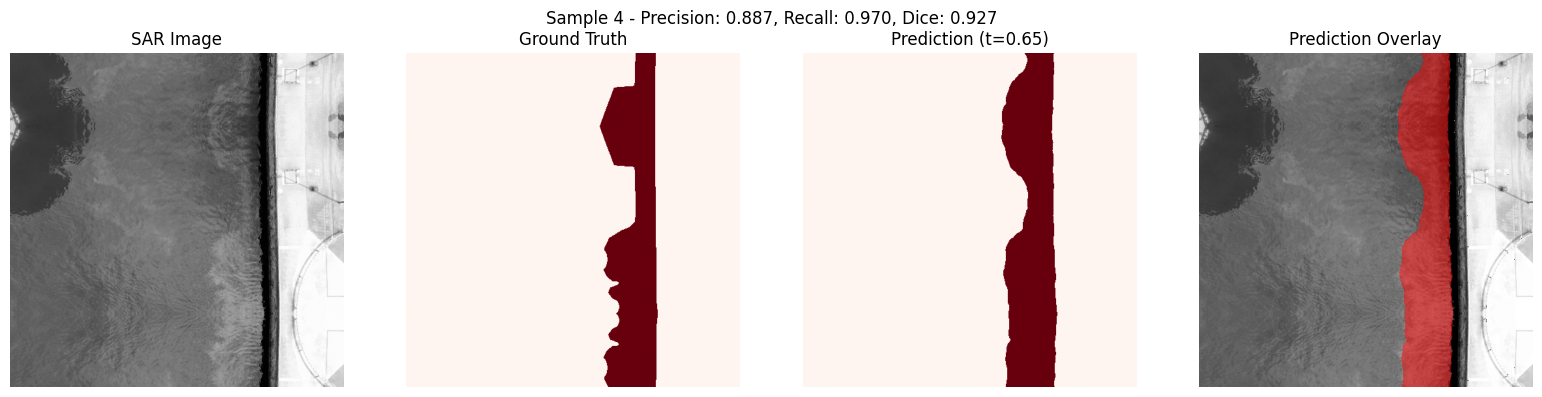

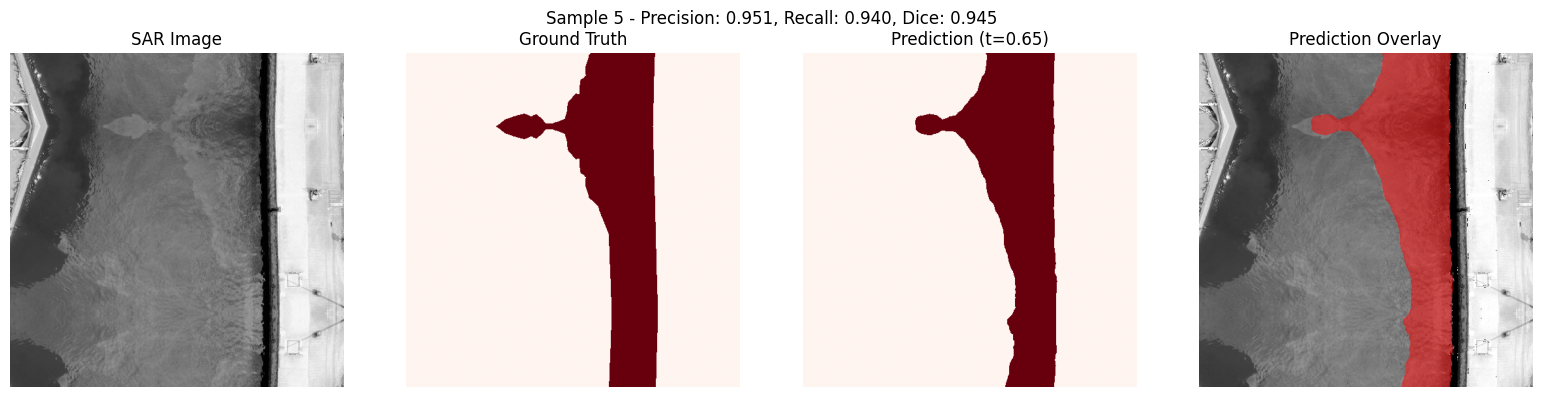

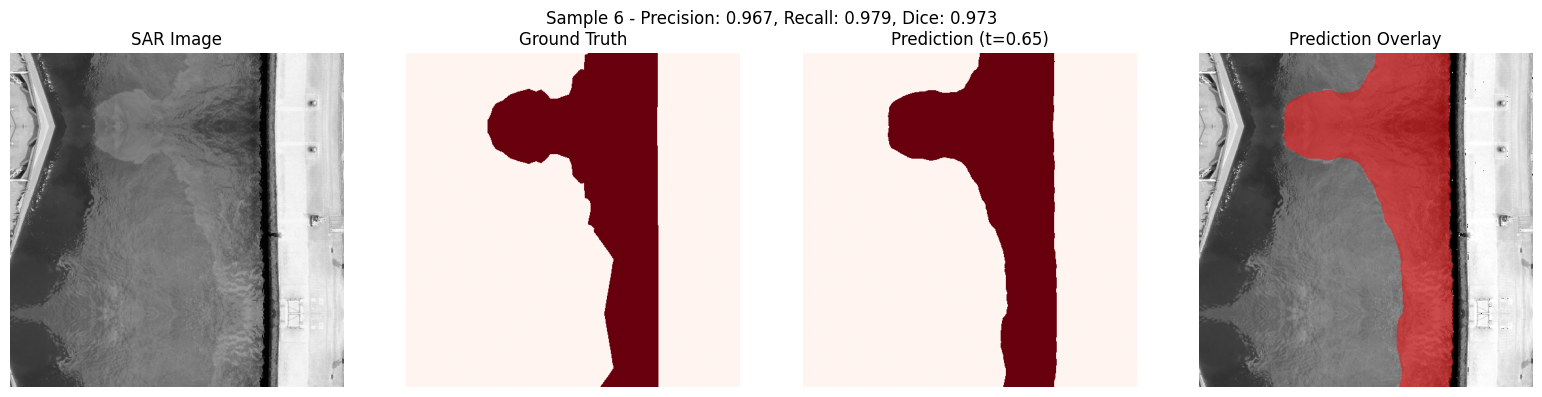


✅ Visualization completed! Showed 6 samples.


In [ ]:
# Cell 8: Complete Final Test Evaluation and Visualization
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Make sure all required variables exist
try:
    _ = model.training
    print("✓ Model available")
except NameError:
    print("✗ Error: Model not defined. Run model definition cell first.")

try:
    _ = len(loader_test)
    print("✓ Test loader available")
except NameError:
    print("✗ Error: loader_test not defined. You need to create the test dataset.")
    # Quick fix - create loader_test if missing
    TEST_IMAGES_DIR = os.path.join(DATAROOT, "test", "images")
    TEST_MASKS_DIR = os.path.join(DATAROOT, "test", "masks")
    pairs_test, miss_te = build_pairs(TEST_IMAGES_DIR, TEST_MASKS_DIR)
    ds_test = OilSegDataset(pairs_test, eval_tfms, OIL_COLORS)
    loader_test = DataLoader(ds_test, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
    print(f"✓ Created test loader with {len(ds_test)} samples")

try:
    print(f"✓ Best threshold: {best_t}")
except NameError:
    print("✗ Warning: best_t not defined. Using default 0.5")
    best_t = 0.5

# Run evaluation
print("\n" + "="*50)
print("RUNNING FINAL TEST EVALUATION")
print("="*50)

test_loss, test_metrics = eval_epoch(model, loader_test, threshold=best_t)
test_roc, test_pr = pr_roc_auc_over_dataset(model, loader_test, sample_max=300)

print("Test Loss:", f"{test_loss:.4f}")
print("Test Metrics:")
for metric, value in test_metrics.items():
    print(f"  {metric.capitalize()}: {value:.4f}")
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test PR-AUC: {test_pr:.4f}")

print("\n" + "="*50)
print("VISUALIZING PREDICTIONS")
print("="*50)

# Fixed visualization functions
def overlay_mask(img3, mask_pred, alpha=0.4):
    """
    img3: tensor [3,H,W] 0..1
    mask_pred: numpy array [H,W] {0,1}
    """
    # Convert image to numpy and ensure proper format
    if isinstance(img3, torch.Tensor):
        img = img3.permute(1,2,0).cpu().numpy()
    else:
        img = img3

    # Convert to 0-255 range
    img = (img * 255).astype(np.uint8)

    # Create red overlay for oil predictions
    overlay = img.copy()
    if len(overlay.shape) == 2:  # Grayscale - convert to RGB
        overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB)
    elif overlay.shape[2] == 3:  # RGB - ensure correct channel order
        overlay = overlay.copy()

    # Create red mask overlay
    red_mask = np.zeros_like(overlay)
    red_mask[..., 0] = 255  # Red channel

    # Apply overlay only where predictions exist
    mask_bool = (mask_pred > 0)
    if np.any(mask_bool):
        overlay[mask_bool] = cv2.addWeighted(
            overlay[mask_bool], 1-alpha,
            red_mask[mask_bool], alpha, 0
        )

    return overlay

@torch.no_grad()
def visualize_samples(model, loader, num=6, threshold=best_t):
    """Visualize model predictions on test samples"""
    model.eval()
    shown = 0

    print(f"Generating {num} visualizations with threshold {threshold:.3f}...")

    for batch_idx, (x, y) in enumerate(loader):
        x = x.to(device)

        # Get model predictions
        logits = model(x)
        probs = torch.sigmoid(logits).squeeze(1)
        preds = (probs >= threshold).cpu().numpy()

        # Process each sample in the batch
        for i in range(len(x)):
            if shown >= num:
                return

            # Prepare data for visualization
            img_tensor = x[i].cpu()
            pred_mask = preds[i]
            gt_mask = y[i].cpu().numpy()

            # Create overlay
            overlay = overlay_mask(img_tensor, pred_mask, alpha=0.5)

            # Create visualization
            fig, axs = plt.subplots(1, 4, figsize=(16, 4))

            # Original SAR image (grayscale)
            img_gray = img_tensor[0].numpy()  # Use first channel
            axs[0].imshow(img_gray, cmap="gray")
            axs[0].set_title("SAR Image")
            axs[0].axis("off")

            # Ground truth mask
            axs[1].imshow(gt_mask, cmap="Reds", vmin=0, vmax=1)
            axs[1].set_title("Ground Truth")
            axs[1].axis("off")

            # Prediction mask
            axs[2].imshow(pred_mask, cmap="Reds", vmin=0, vmax=1)
            axs[2].set_title(f"Prediction (t={threshold:.2f})")
            axs[2].axis("off")

            # Overlay
            axs[3].imshow(overlay)
            axs[3].set_title("Prediction Overlay")
            axs[3].axis("off")

            # Add metrics for this sample
            tp = np.sum((pred_mask == 1) & (gt_mask == 1))
            fp = np.sum((pred_mask == 1) & (gt_mask == 0))
            fn = np.sum((pred_mask == 0) & (gt_mask == 1))

            if tp + fp > 0:
                precision = tp / (tp + fp)
            else:
                precision = 0.0

            if tp + fn > 0:
                recall = tp / (tp + fn)
            else:
                recall = 0.0

            if tp + fp + fn > 0:
                dice = 2 * tp / (2 * tp + fp + fn)
            else:
                dice = 1.0 if (pred_mask == gt_mask).all() else 0.0

            plt.suptitle(f"Sample {shown+1} - Precision: {precision:.3f}, Recall: {recall:.3f}, Dice: {dice:.3f}")
            plt.tight_layout()
            plt.show()

            shown += 1

            if shown >= num:
                return

# Run visualization
visualize_samples(model, loader_test, num=6, threshold=best_t)

print(f"\n✅ Visualization completed! Showed {min(6, len(loader_test.dataset))} samples.")


In [ ]:
# Cell: SpillGuard Gradio Deployment Interface
import gradio as gr
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import io
import base64
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Install gradio if not already installed
!pip install gradio

# Global variables for model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = None
best_threshold = 0.65  # Use your optimized threshold

# Load your trained model
def load_spillguard_model():
    global model

    ENCODER = "resnet50"
    WEIGHTS = "imagenet"
    CLASSES = 1

    model = smp.DeepLabV3Plus(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=CLASSES
    ).to(device)

    BEST_PATH = "/content/drive/MyDrive/oilspill_ckpts/deeplabv3p_best.pth"  # Adjust path as needed

    try:
        checkpoint = torch.load(BEST_PATH, map_location='cpu')
        if 'model' in checkpoint:
            model.load_state_dict({k: v.to(device) for k, v in checkpoint['model'].items()})
        else:
            model.load_state_dict(checkpoint)
        model.eval()
        print("✅ SpillGuard model loaded successfully!")
        return True
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return False


# Image preprocessing function
def preprocess_image(image):
    """Preprocess uploaded image for model inference"""
    IMG_SIZE = 512

    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image

    # Convert to grayscale if RGB
    if len(img_array.shape) == 3:
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_array

    # Normalize to [0,1]
    img_gray = img_gray.astype(np.float32)
    if img_gray.max() > 1:
        img_gray = img_gray / 255.0

    # Apply your SAR preprocessing (same as training)
    lo, hi = np.percentile(img_gray, [1, 99])
    if hi > lo:
        img_gray = np.clip(img_gray, lo, hi)
        img_gray = (img_gray - lo) / (hi - lo)

    # Create 3-channel image
    img_3ch = np.stack([img_gray, img_gray, img_gray], axis=2)

    # Apply transformations
    transform = A.Compose([
        A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
        A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
        A.ToFloat(max_value=1.0),
        ToTensorV2(),
    ])

    transformed = transform(image=img_3ch)
    img_tensor = transformed['image'].unsqueeze(0).to(device)  # Add batch dimension

    return img_tensor, img_gray

# Fixed oil spill detection function
@torch.no_grad()
def detect_oil_spill(image, threshold):
    """Fixed detection function with proper dimension handling"""
    global model

    if model is None:
        return None, "❌ Model not loaded. Please restart the interface."

    try:
        # Store original image dimensions
        if isinstance(image, Image.Image):
            original_image = np.array(image)
        else:
            original_image = image

        original_height, original_width = original_image.shape[:2]

        # Preprocess image for model (this resizes to 512x512)
        img_tensor, processed_gray = preprocess_image(image)

        # Get model prediction (will be 512x512)
        logits = model(img_tensor)
        probabilities = torch.sigmoid(logits).squeeze().cpu().numpy()

        # Resize predictions back to original image dimensions
        probabilities_resized = cv2.resize(
            probabilities,
            (original_width, original_height),
            interpolation=cv2.INTER_LINEAR
        )

        # Apply threshold to resized predictions
        prediction_mask = (probabilities_resized >= threshold).astype(np.uint8)

        # Prepare original image for visualization
        if len(original_image.shape) == 3:
            original_gray = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
        else:
            original_gray = original_image

        # Normalize original image
        if original_gray.max() > 1:
            original_gray = original_gray.astype(np.float32) / 255.0

        # Calculate statistics
        total_pixels = prediction_mask.size
        oil_pixels = np.sum(prediction_mask)
        oil_percentage = (oil_pixels / total_pixels) * 100

        # Create visualization with fixed dimensions
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('SpillGuard Oil Spill Detection Results', fontsize=16, fontweight='bold')

        # Original image
        axes[0,0].imshow(original_gray, cmap='gray')
        axes[0,0].set_title(f'Input Image ({original_width}x{original_height})')
        axes[0,0].axis('off')

        # Probability heatmap (resized to original dimensions)
        im1 = axes[0,1].imshow(probabilities_resized, cmap='hot', vmin=0, vmax=1)
        axes[0,1].set_title('Oil Spill Probability')
        axes[0,1].axis('off')
        plt.colorbar(im1, ax=axes[0,1], fraction=0.046)

        # Binary prediction
        axes[1,0].imshow(prediction_mask, cmap='Reds', vmin=0, vmax=1)
        axes[1,0].set_title(f'Detection (Threshold: {threshold:.2f})')
        axes[1,0].axis('off')

        # Create overlay with proper dimensions
        overlay_base = (original_gray * 255).astype(np.uint8)
        if len(overlay_base.shape) == 2:
            overlay_rgb = cv2.cvtColor(overlay_base, cv2.COLOR_GRAY2RGB)
        else:
            overlay_rgb = overlay_base.copy()

        # Apply red overlay only where oil is detected
        overlay_colored = overlay_rgb.copy()
        mask_indices = prediction_mask == 1
        if np.any(mask_indices):
            overlay_colored[mask_indices] = [255, 0, 0]  # Red for oil

        # Blend the overlay
        blended = cv2.addWeighted(overlay_rgb, 0.7, overlay_colored, 0.3, 0)

        axes[1,1].imshow(blended)
        axes[1,1].set_title('Oil Spill Overlay')
        axes[1,1].axis('off')

        plt.tight_layout()

        # Save plot to bytes
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)
        plt.close()

        # Convert to PIL Image for Gradio
        result_image = Image.open(buf)

        # Create results text
        confidence = np.max(probabilities_resized)
        avg_prob = np.mean(probabilities_resized)

        results_text = f"""
🛢️ **SpillGuard Detection Results**

📊 **Image Info:**
• Original Size: {original_width} × {original_height} pixels
• Processing: Resized to 512×512 for model, results scaled back

📊 **Detection Statistics:**
• Oil Coverage: {oil_percentage:.2f}% of image
• Oil Pixels: {oil_pixels:,} / {total_pixels:,}
• Max Confidence: {confidence:.3f}
• Average Probability: {avg_prob:.3f}

🎯 **Assessment:**
• Threshold Used: {threshold:.2f}
• Severity: {'HIGH' if oil_percentage > 10 else 'MODERATE' if oil_percentage > 5 else 'LOW' if oil_percentage > 1 else 'MINIMAL'}

   **Status:**
   {'🚨 OIL SPILL DETECTED' if oil_percentage > 1 else '✅ No significant oil detected'}

        """

        return result_image, results_text.strip()

    except Exception as e:
        error_msg = f"❌ **Error during detection:**\n{str(e)}\n\nDebug info:\n• Image shape: {getattr(image, 'size', 'Unknown')}\n• Model loaded: {model is not None}"
        return None, error_msg

# Enhanced preprocessing function
def preprocess_image(image):
    """Enhanced preprocessing with better dimension handling"""
    IMG_SIZE = 512

    # Convert PIL to numpy if needed
    if isinstance(image, Image.Image):
        img_array = np.array(image)
    else:
        img_array = image.copy()

    # Convert to grayscale if RGB
    if len(img_array.shape) == 3:
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_array

    # Normalize to [0,1]
    img_gray = img_gray.astype(np.float32)
    if img_gray.max() > 1:
        img_gray = img_gray / 255.0

    # Apply SAR preprocessing
    lo, hi = np.percentile(img_gray, [1, 99])
    if hi > lo:
        img_gray = np.clip(img_gray, lo, hi)
        img_gray = (img_gray - lo) / (hi - lo)
    else:
        img_gray = (img_gray - img_gray.min()) / (img_gray.ptp() + 1e-6)

    # Create 3-channel image
    img_3ch = np.stack([img_gray, img_gray, img_gray], axis=2)

    # Apply transformations
    import albumentations as A
    from albumentations.pytorch.transforms import ToTensorV2

    transform = A.Compose([
        A.LongestMaxSize(max_size=IMG_SIZE, interpolation=cv2.INTER_CUBIC),
        A.PadIfNeeded(IMG_SIZE, IMG_SIZE, border_mode=cv2.BORDER_REFLECT_101),
        A.ToFloat(max_value=1.0),
        ToTensorV2(),
    ])

    transformed = transform(image=img_3ch)
    img_tensor = transformed['image'].unsqueeze(0).to(device)

    return img_tensor, img_gray

# Create the interface (same as before)
def create_spillguard_interface():
    with gr.Blocks(title="SpillGuard - Oil Spill Detection System", theme=gr.themes.Soft()) as interface:

        gr.Markdown("""
        # 🛢️ SpillGuard - AI Oil Spill Detection System

        **Upload a SAR (Synthetic Aperture Radar) satellite image to detect oil spills in marine environments.**

        *Model processes images at 512×512 resolution and scales results back to original dimensions.*
        """)

        with gr.Row():
            with gr.Column(scale=1):
                gr.Markdown("### 📤 Input")

                image_input = gr.Image(
                    label="Upload SAR Image",
                    type="pil",
                    height=300
                )

                threshold_slider = gr.Slider(
                    minimum=0.1,
                    maximum=0.9,
                    value=0.65,
                    step=0.05,
                    label="Detection Threshold",
                    info="Lower values = more sensitive detection"
                )

                detect_btn = gr.Button(
                    "🔍 Detect Oil Spills",
                    variant="primary",
                    size="lg"
                )

                gr.Markdown("""
                ### 📋 Instructions:
                1. Upload any size SAR satellite image
                2. Adjust detection threshold (0.65 recommended)
                3. Click "Detect Oil Spills"
                4. Results are automatically scaled to original image size
                """)

            with gr.Column(scale=2):
                gr.Markdown("### 📊 Results")

                result_image = gr.Image(
                    label="Detection Results",
                    height=500
                )

                result_text = gr.Markdown(
                    "Upload an image and click 'Detect Oil Spills' to see results here."
                )

        # Connect the interface
        detect_btn.click(
            fn=detect_oil_spill,
            inputs=[image_input, threshold_slider],
            outputs=[result_image, result_text]
        )

        gr.Markdown("""
        ---
        ⚠️ **Note:** This is an AI-based analysis. For critical decisions, please verify with additional sources.<br><br>
        **SpillGuard v1.1** | Fixed dimension handling | DeepLabV3+ & PyTorch
        """)

    return interface

model_loaded = load_spillguard_model()

# Launch the fixed interface
if model_loaded:
    spillguard_app = create_spillguard_interface()
    spillguard_app.launch(share=True, debug=True)
    print("🚀 Fixed SpillGuard interface launched!")
else:
    print("❌ Model not loaded. Please check model path.")


✅ SpillGuard model loaded successfully!
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://dc4d02b3fe8b247105.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://dc4d02b3fe8b247105.gradio.live
🚀 Fixed SpillGuard interface launched!
